In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data_offers = pd.read_csv('datasets/data_offers.csv')
data_orders = pd.read_csv('datasets/data_orders.csv')
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [4]:
len(data_orders)

10716

In [41]:
data_offers['offer_count'] = data_offers.groupby('order_gk')['offer_id'].transform('count')
data_offers = data_offers.drop(columns=['offer_id'])
data_offers = data_offers.drop_duplicates()

# 1

- There are several reasons:

    - `is_driver_assigned_key==1` means user canceled the order althought there are answers
    - `is_driver_assigned_key==0` && 'cancellations_time_in_seconds!=0' means that the customs cannot wait for an answer and cancel the order.
    - `is_driver_assigned_key==0` &&    `cancellations_time_in_seconds==0` means that the order is cancled by system

In [42]:
merged_data = pd.merge(data_orders, data_offers, on='order_gk', how='left')

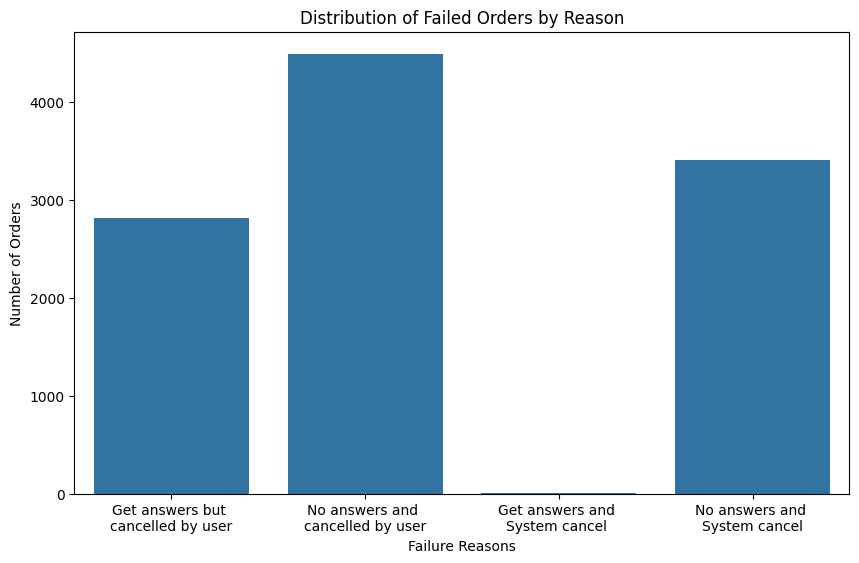

In [43]:
failure_reasons = {
    'Get answers but \ncancelled by user': merged_data[(merged_data['is_driver_assigned_key'] == 1) & (merged_data['order_status_key'] == 4)],
    'No answers and \ncancelled by user': merged_data[(merged_data['is_driver_assigned_key'] == 0) & (merged_data['order_status_key'] == 4)],
    'Get answers and \nSystem cancel ': merged_data[(merged_data['is_driver_assigned_key'] == 1) & (merged_data['order_status_key'] == 9)],
    'No answers and \nSystem cancel': merged_data[(merged_data['is_driver_assigned_key'] == 0) & (merged_data['order_status_key'] == 9)],
}

failure_counts = {reason: df.shape[0] for reason, df in failure_reasons.items()}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(failure_counts.keys()), y=list(failure_counts.values()))
plt.title('Distribution of Failed Orders by Reason')
plt.xlabel('Failure Reasons')
plt.ylabel('Number of Orders')
plt.show()

The histogram shows that:

- If there are no answers, the proportion of cancellation by users is larger.
- Group by answer or not, we can find that if there are no answers the order is more probable to be cancelled.
- Group by user or system, we can find that the order is more probable to be cancelled by users.

# 2

In [ ]:
merged_data['order_datetime'] = pd.to_datetime(merged_data['order_datetime'])
merged_data['hour'] = merged_data['order_datetime'].dt.hour
merged_data.head(10)

/var/folders/01/36vqvpjs78j_nk7k49q3t3w00000gn/T/ipykernel_59174/3199132246.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_datetime'] = pd.to_datetime(df['order_datetime'])
/var/folders/01/36vqvpjs78j_nk7k49q3t3w00000gn/T/ipykernel_59174/3199132246.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['order_datetime'].dt.hour
/var/folders/01/36vqvpjs78j_nk7k49q3t3w00000gn/T/ipykernel_59174/3199132246.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

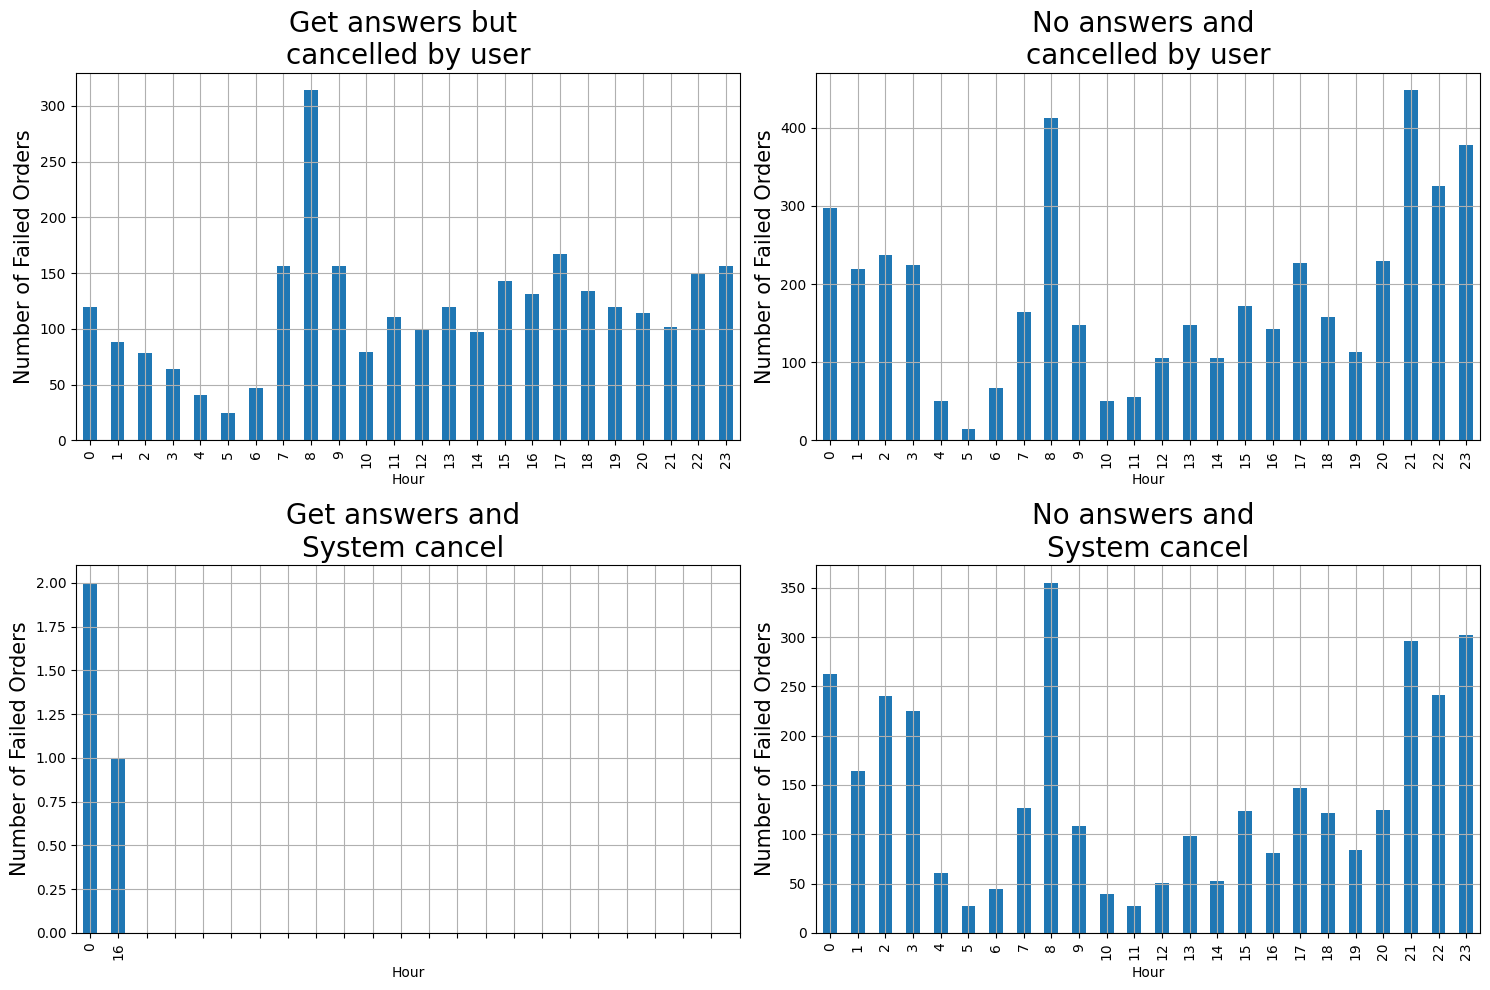

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 创建一个2x2的图形布局

for i, (reason, df) in enumerate(failure_reasons.items()):
    ax = axs[i // 2, i % 2]  # 计算当前子图的索引
    df['order_datetime'] = pd.to_datetime(df['order_datetime'])
    df['hour'] = df['order_datetime'].dt.hour
    failure_counts_by_hour = df.groupby('hour').size()
    failure_counts_by_hour.plot.bar(ax=ax)  # 在指定的子图中绘制柱状图
    ax.set_title(f'{reason}', fontsize=20)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Number of Failed Orders', fontsize=15)
    ax.set_xticks(range(24))
    ax.grid(True)

plt.tight_layout()  # 调整子图布局以防止重叠
plt.show()

Explanation for Distribution of Failed Orders by hours:

- `Get answers and system cancel` has a discrete distribution which may because of regular system error.
- The distribution of other three have apparently correlation with time interval. They all show a high distribution around 8 a.m, which must due to morning peak. Lots of people order the car for work, which leads to crowded flow. Also, few failures occurred just before morning peak.
- `Get answers but cancelled by user` distributed reletively uniformly other times of the day, even during night.
- `No answers and cancelled by user` distributed more and more until the midnight. There is a valley around 19 p.m, which may because that people tend to wait after work.
- `No answers and system cancel` distributed more after 21 p.m, except for morning peak.

# 3

The chart shows that:

- In each time interval, the average time to cancellation for assigned driver is more than that if no driver assign. Which means if there are drivers assigning, there may take it longer for cancellation.

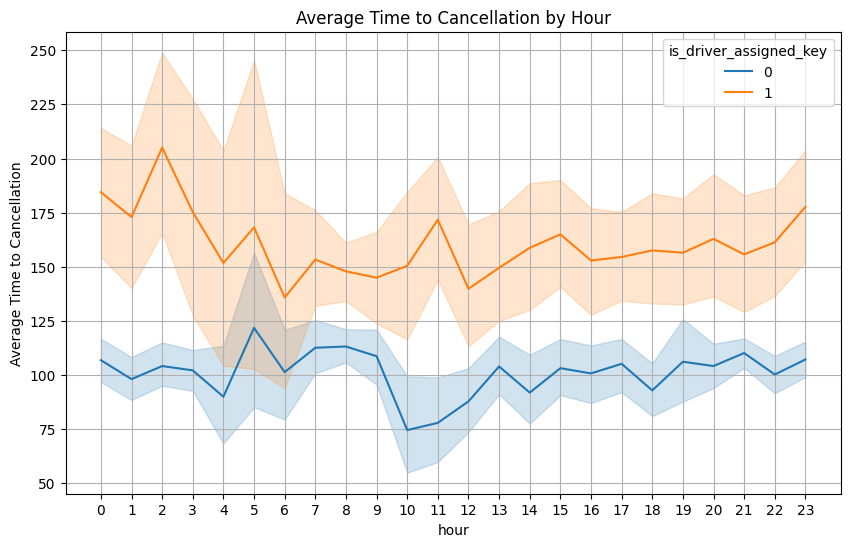

In [46]:
merged_data['cancellations_time_in_seconds_a'] = (merged_data['cancellations_time_in_seconds'] - merged_data['cancellations_time_in_seconds'].mean()) / merged_data['cancellations_time_in_seconds'].std()
merged_data = merged_data[merged_data['cancellations_time_in_seconds_a'].between(-2, 2)]

plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='cancellations_time_in_seconds', hue='is_driver_assigned_key', data=merged_data)
plt.title('Average Time to Cancellation by Hour')
# I want to show ever hour on the x-axis
plt.xticks(range(24))
# plt.xlabel('Hour')
plt.ylabel('Average Time to Cancellation')
plt.grid(True)
plt.show()

In [47]:
cancelled_orders = merged_data[merged_data['order_status_key'] == 4]
cancelled_orders_with_driver = cancelled_orders[cancelled_orders['is_driver_assigned_key'] == 1]
cancelled_orders_without_driver = cancelled_orders[cancelled_orders['is_driver_assigned_key'] == 0]

In [48]:
avg_cancel_time_with_driver = cancelled_orders_with_driver['cancellations_time_in_seconds'].mean()
avg_cancel_time_without_driver = cancelled_orders_without_driver['cancellations_time_in_seconds'].mean()

In [49]:
print("Average cancellation time with driver:", avg_cancel_time_with_driver)
print("Average cancellation time without driver:", avg_cancel_time_without_driver)

Average cancellation time with driver: 159.16442687747036
Average cancellation time without driver: 103.89638932496075


# 4

- The result shows that there are peaks at around 8 a.m and 17 p.m which corresponse to the morning peak and evening peak.

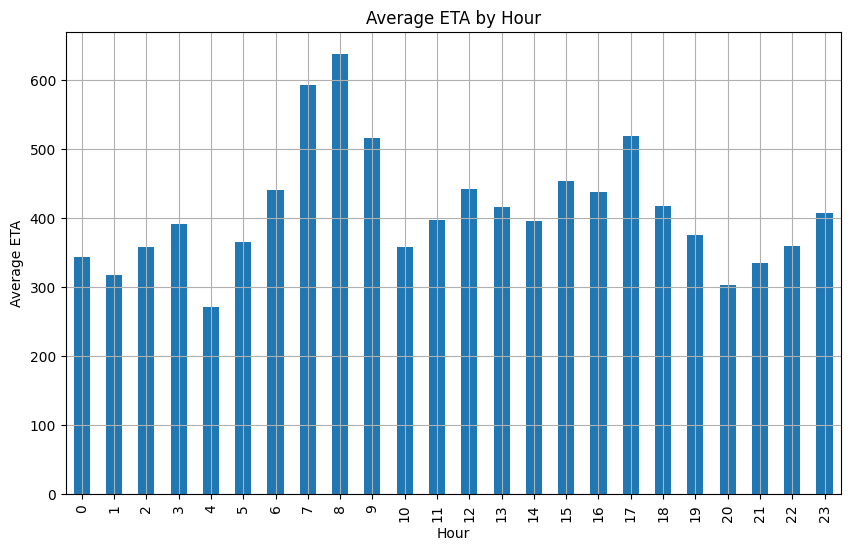

In [50]:
avg_eta_by_hour = merged_data.groupby('hour')['m_order_eta'].mean()

plt.figure(figsize=(10, 6))
avg_eta_by_hour.plot.bar()
plt.title('Average ETA by Hour')
plt.xlabel('Hour')
plt.ylabel('Average ETA')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# 5

In [51]:
len(merged_data)

6989

In [5]:
import folium
import h3

# Calculate the hexagons
hexagons = {}
for index, row in data_orders.iterrows():
# for index, row in merged_data.iterrows():
    lat, lon = row['origin_latitude'], row['origin_longitude']
    h3_index = h3.geo_to_h3(lat, lon, 8)
    if h3_index in hexagons:
        hexagons[h3_index] += 1
    else:
        hexagons[h3_index] = 1
# Sort the hexagons by the number of orders
sorted_hexagons = sorted(hexagons.items(), key=lambda x: x[1], reverse=True)
print(sorted_hexagons)


[('88195d2b1dfffff', 1497), ('88195d2b1bfffff', 870), ('88195d2b15fffff', 774), ('88195d2b11fffff', 707), ('88195d2b19fffff', 667), ('88195d284dfffff', 653), ('88195d2a27fffff', 414), ('88195d2b0bfffff', 372), ('88195d2a25fffff', 362), ('88195d2b13fffff', 346), ('88195d2b03fffff', 257), ('88195d2b17fffff', 210), ('88195d2b39fffff', 184), ('88195d2861fffff', 182), ('88195d2a21fffff', 156), ('88195d2b3dfffff', 153), ('88195d2b31fffff', 143), ('88195d2869fffff', 125), ('88195d2b3bfffff', 115), ('88195d2b51fffff', 98), ('88195d2b57fffff', 92), ('88195d2a23fffff', 91), ('88195d2b55fffff', 85), ('88195d2b09fffff', 81), ('88195d2845fffff', 80), ('88195d2847fffff', 80), ('88195d2b07fffff', 74), ('88195d2b0dfffff', 69), ('88195d2843fffff', 68), ('88195d2841fffff', 66), ('88195d282dfffff', 60), ('88195d2867fffff', 59), ('88195d2a35fffff', 56), ('88195d2b01fffff', 55), ('88195d2863fffff', 54), ('88195d280dfffff', 52), ('88195d2b23fffff', 49), ('88195d2a3dfffff', 40), ('88195d2a2dfffff', 40), ('88

In [6]:
print(data_orders.shape)

(10716, 8)


- The red regions are added to 80-percent of all orders, while the rest is less than 20% as the sum.

In [9]:
# Calculate the number of hexagons that contain 80% of all orders
# total_orders = merged_data.shape[0]
total_orders = data_orders.shape[0]
cumulative_orders = 0
hexagons_80_percent = []
other_hexagons = []

for h3_index, count in sorted_hexagons:
    cumulative_orders += count
    if cumulative_orders >= 0.8 * total_orders:
        other_hexagons.append(h3_index)
        continue
    hexagons_80_percent.append(h3_index)


# Create a map
# m = folium.Map(location=[merged_data['origin_latitude'].mean(), merged_data['origin_longitude'].mean()], zoom_start=10)
m = folium.Map(location=[data_orders['origin_latitude'].mean(), data_orders['origin_longitude'].mean()], zoom_start=10)

for h3_index in other_hexagons:
    boundary = h3.h3_to_geo_boundary(h3_index)
    folium.Polygon(locations=boundary, color='blue', fill=True, fill_color='blue').add_to(m)


# Add the hexagons to the map
for h3_index in hexagons_80_percent:
    boundary = h3.h3_to_geo_boundary(h3_index)
    folium.Polygon(locations=boundary, color='red', fill=True, fill_color='blue').add_to(m)


# Display the map
m.save('hexagons.html')